# Full-waveform inversion Marmousi2 example

In this notebook, we run the FWI script to retrieve the subsurface velocity model from seismograms recorded at the Earth surface. The FWI cost function is written as follows,
\begin{eqnarray}
\phi(\mathbf{m}) = \frac{1}{2}\|\mathbf{f}(\mathbf{m}) - \mathbf{d}_{obs} \|_2^2,
\end{eqnarray}
where $\mathbf{f}$ is the non-linear modeling operator, $\mathbf{m}$ is the unknown velocity model, and $\mathbf{d}_{obs}$ represents the observed seismograms.

## Import modules

In [1]:
# Importing necessary modules
import os
import genericIO
import numpy as np
from scipy.ndimage import gaussian_filter
# Plotting library
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)


## Wavelet

We start by generating the known source wavelet.

In [2]:
# Generate wavelet 
!waveletFloatMain.py timeDelay=0.7 f1=2 f2=5 f3=8 f4=20 type=ali par=parFWI.p wavelet=results/waveletFWI.H

In [3]:
# Reading the wavelet
wavelet = genericIO.defaultIO.getVector("results/waveletFWI.H")
waveletNd = wavelet.getNdArray()
waveletHyper = wavelet.getHyper()
nt = waveletHyper.getAxis(1).n
ot = waveletHyper.getAxis(1).o
dt = waveletHyper.getAxis(1).d

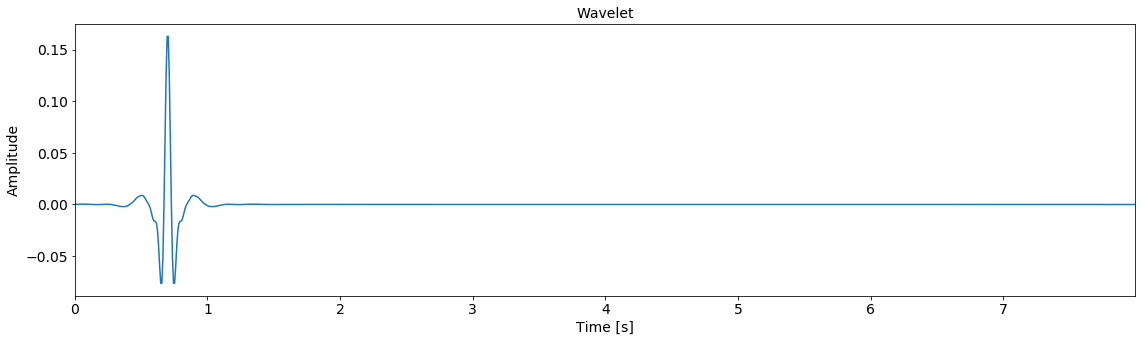

In [4]:
fig,ax=plt.subplots(figsize=(19,5))
time_range = np.linspace(ot,ot+(nt-1)*dt,nt)
plt.plot(np.linspace(ot,ot+(nt-1)*dt,nt), waveletNd)
plt.title('Wavelet'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.show()

## Generate data

In [5]:
# Reading Marmousi model as a vector
MarmVel = genericIO.defaultIO.getVector("velocityMarmousi.H")
MarmVelNd = MarmVel.getNdArray()
MarmHyper = MarmVel.getHyper()
# Getting axes' information
oz = MarmHyper.getAxis(1).o
dz = MarmHyper.getAxis(1).d
nz = MarmHyper.getAxis(1).n
ox = MarmHyper.getAxis(2).o
dx = MarmHyper.getAxis(2).d
nx = MarmHyper.getAxis(2).n

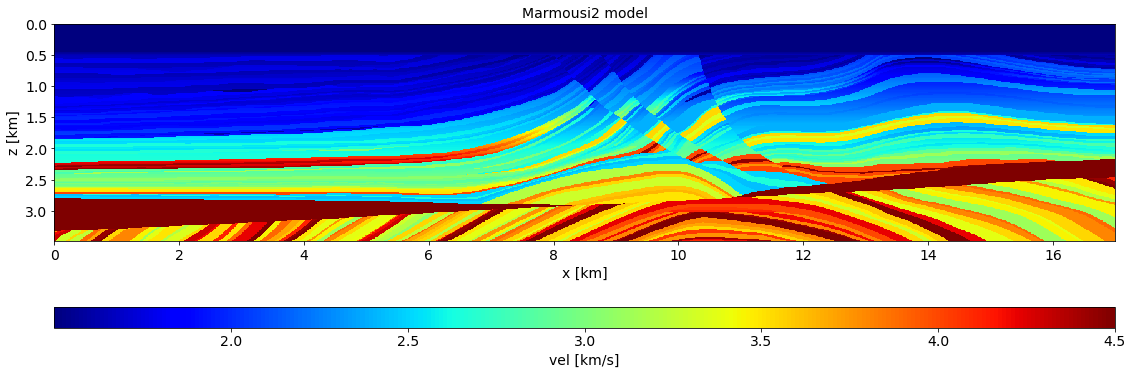

In [6]:
plt.figure(figsize=(19,8))
plt.imshow(MarmVelNd.T,cmap='jet', vmin=MarmVel.min(), vmax=MarmVel.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Marmousi2 model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.show()

In [7]:
# Pad Marmousi velocity model
!padFileGpuMain zPad=100 xPad=100 model=velocityMarmousi.H data=velocityMarmousi.pad.H

 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 


In [8]:
# Running non-linear operator to generate acoustic data
!nonlinearPythonFloatMain.py info=0 par=parFWI.p model=results/waveletFWI.H vel=velocityMarmousi.pad.H data=results/dataFWI.H

-------------------------------------------------------------------
------------------ Running Python nonlinear forward ---------------
-------------------- Single precision Python code -----------------
-------------------------------------------------------------------

-------------------------------------------------------------------
--------------------------- All done ------------------------------
-------------------------------------------------------------------



Let's plot three representative shot gathers that have been generated.

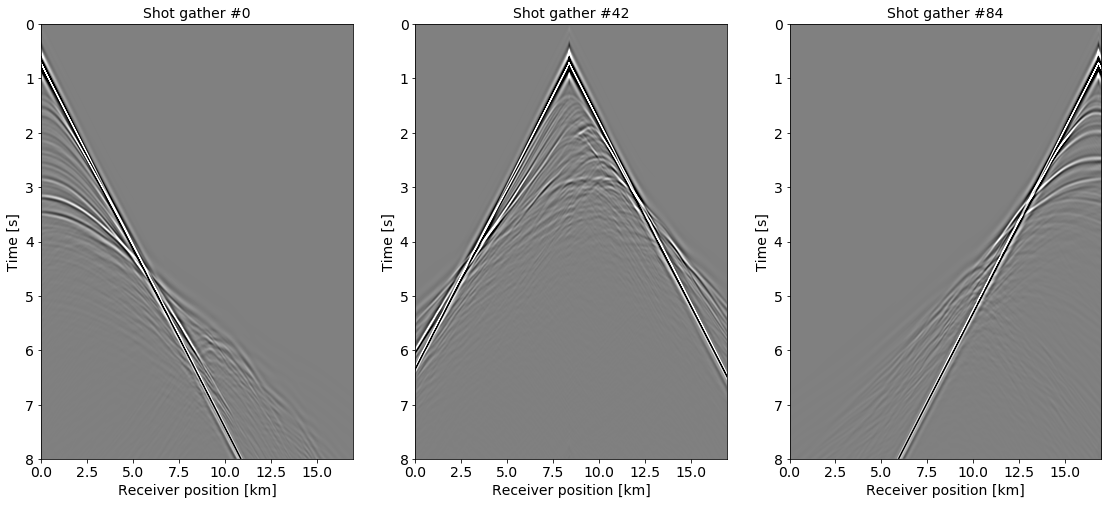

In [9]:
# Plotting the data
dataMarmNd = genericIO.defaultIO.getVector("results/dataFWI.H").getNdArray()
clipVal = np.percentile(np.absolute(dataMarmNd[10,:,:]),99.0)

plt.figure(figsize=(19,8))

plt.subplot(131), plt.title("Shot gather #%s"%(0))
plt.imshow(dataMarmNd[0,:,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [km]"), plt.ylabel("Time [s]")

plt.subplot(132), plt.title("Shot gather #%s"%(42))
plt.imshow(dataMarmNd[42,:,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [km]"), plt.ylabel("Time [s]")

plt.subplot(133), plt.title("Shot gather #%s"%(84))
plt.imshow(dataMarmNd[-1,:,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [km]"), plt.ylabel("Time [s]")

plt.show()

## Creating starting velocity guess

We are going to smooth the true model to obtain the initial velocity guess.

In [10]:
MarmVelSmooth = MarmVel.clone()
MarmVelSmoothNd = MarmVelSmooth.getNdArray()
MarmVelSmoothNd[:] = gaussian_filter(MarmVelNd, sigma=10)
MarmVelSmooth.writeVec("results/velocityMarmousiSmooth.H")

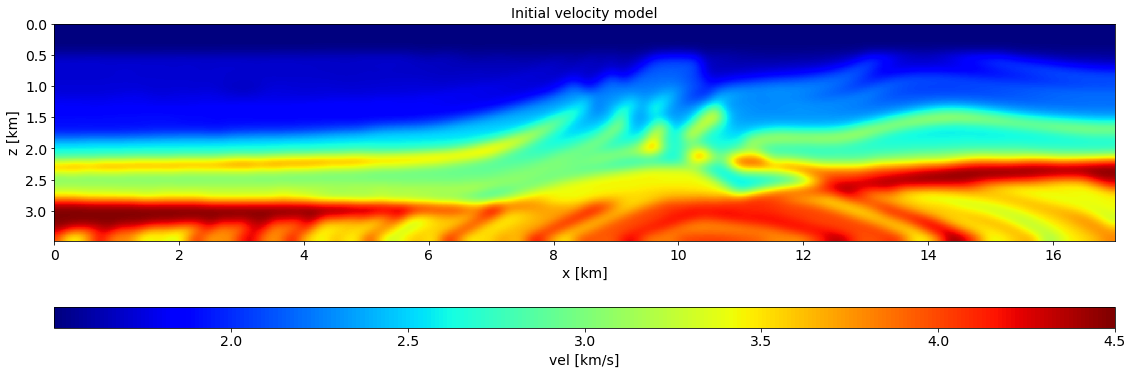

In [11]:
plt.figure(figsize=(19,8))
plt.imshow(MarmVelSmoothNd.T,cmap='jet', vmin=MarmVel.min(), vmax=MarmVel.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Initial velocity model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.show()

In [12]:
# Pad Marmousi velocity model
!padFileGpuMain zPad=100 xPad=100 model=results/velocityMarmousiSmooth.H data=results/velocityMarmousiSmooth.pad.H

 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 


## FWI process

We can now employ the FWI script to invert the true seismograms starting the inversion process from the smoothed velocity model. Since we do not employ any multiscale approach here, we do not expect to retrieve the true velocity model.

In [ ]:
!fwiMain.py par=parFWI.p sources=results/waveletFWI.H vel=results/velocityMarmousiSmooth.pad.H data=results/dataFWI.H nIter=2000 folder=results prefix=FWI minBound=1.3 maxBound=5.0 solver=lbfgs m_steps=50


-------------------------------------------------------------------
------------------------ Conventional FWI -------------------------
-------------------------------------------------------------------

##########################################################################################
Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) algorithm 
Maximum number of steps to be used for Hessian inverse estimation: 50 
Restart folder: /net/friday/scr2/ettore/restart_2020-07-20T17-22-38.727410/
##########################################################################################

iter = 0000, obj = 4.21944e-08, resnorm = 2.90e-04, gradnorm = 1.65e-08, feval = 1, geval = 1
iter = 0001, obj = 2.85346e-08, resnorm = 2.39e-04, gradnorm = 6.21e-09, feval = 2, geval = 2
iter = 0002, obj = 2.54756e-08, resnorm = 2.26e-04, gradnorm = 5.33e-09, feval = 3, geval = 3
iter = 0003, obj = 2.27600e-08, resnorm = 2.13e-04, gradnorm = 5.62e-09, feval = 4, geval = 4
iter = 0004, obj = 1.

iter = 0080, obj = 4.44553e-09, resnorm = 9.43e-05, gradnorm = 4.02e-10, feval = 81, geval = 81
iter = 0081, obj = 4.42278e-09, resnorm = 9.41e-05, gradnorm = 4.55e-10, feval = 82, geval = 82
iter = 0082, obj = 4.38745e-09, resnorm = 9.37e-05, gradnorm = 5.71e-10, feval = 83, geval = 83
iter = 0083, obj = 4.33768e-09, resnorm = 9.31e-05, gradnorm = 6.23e-10, feval = 84, geval = 84
iter = 0084, obj = 4.29181e-09, resnorm = 9.26e-05, gradnorm = 5.01e-10, feval = 85, geval = 85
iter = 0085, obj = 4.26507e-09, resnorm = 9.24e-05, gradnorm = 3.70e-10, feval = 86, geval = 86
iter = 0086, obj = 4.24801e-09, resnorm = 9.22e-05, gradnorm = 3.75e-10, feval = 87, geval = 87
iter = 0087, obj = 4.22657e-09, resnorm = 9.19e-05, gradnorm = 4.43e-10, feval = 88, geval = 88
iter = 0088, obj = 4.19473e-09, resnorm = 9.16e-05, gradnorm = 4.94e-10, feval = 89, geval = 89
iter = 0089, obj = 4.16089e-09, resnorm = 9.12e-05, gradnorm = 4.42e-10, feval = 90, geval = 90
iter = 0090, obj = 4.13614e-09, resnorm 

Let's have a look at the final inverted model.

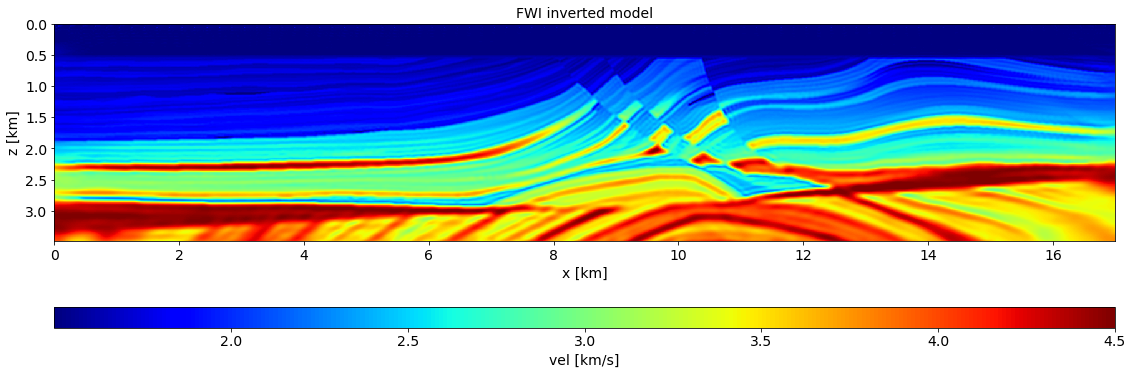

In [18]:
# Reading and plotting inverted model as a vector
MarmVelFWI = genericIO.defaultIO.getVector("results/FWI_inv_mod.H")
# Removing absorbing boundaries
MarmVelFWINd = MarmVelFWI.getNdArray()[100:1800,100:450]
plt.figure(figsize=(19,8))
plt.imshow(MarmVelFWINd.T,cmap='jet', vmin=MarmVel.min(), vmax=MarmVel.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("FWI inverted model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.show()

Also, it is important to plot the cost function versus the number of iterations.

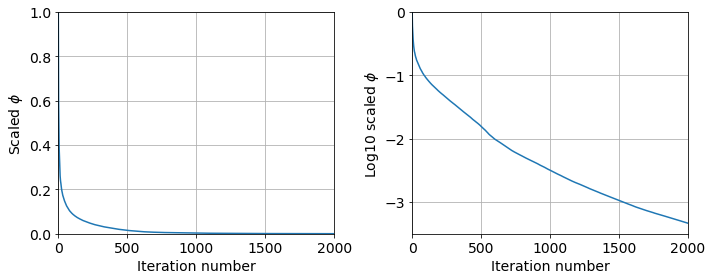

In [19]:
# Reading and plotting the FWI objective function
objFWI = genericIO.defaultIO.getVector("results/FWI_obj.H")
objFWINd = objFWI.getNdArray()

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(objFWINd/objFWINd[0])
# plt.title("LCG convergence")
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([0,1])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.subplot(122)
plt.plot(np.log10(objFWINd/objFWINd[0]))
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Log10 scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([None,0])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()

Finally, to quantitatively assess the efficacy of the FWI step, we compute the following scalar quantity:
\begin{eqnarray}
   \gamma_{FWI} = 100*(1-\|\mathbf{m}-\mathbf{m}_{true}\|_2^2/\|\mathbf{m}_{init}-\mathbf{m}_{true}\|_2^2),
\end{eqnarray}

In [20]:
MarmVelPad = genericIO.defaultIO.getVector("velocityMarmousi.pad.H")
MarmVelNd = MarmVelPad.getNdArray()[100:1800,100:450]
# Computing initial velocity error corrected over iterations
# Reading and plotting inverted models 
MarmVelsFWI = genericIO.defaultIO.getVector("results/FWI_model.H")
# Removing absorbing boundaries
MarmVelsFWINd = MarmVelsFWI.getNdArray()[:,100:1800,100:450]
iterative_error = np.zeros(MarmVelsFWINd.shape[0])
for ii, error in enumerate(iterative_error):
    iterative_error[ii] = np.linalg.norm(MarmVelsFWINd[ii,:]-MarmVelNd)**2

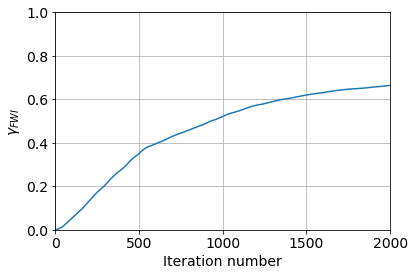

In [21]:
plt.plot(np.linspace(0,(len(iterative_error)-1)*10,len(iterative_error)),1-iterative_error/iterative_error[0])
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("$\gamma_{FWI}$",fontsize=14)
ax = plt.gca() 
plt.ylim([0,1])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)